# LAB 2 -  Grangier-Roger-Aspect experiment

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random

from scipy.optimize import curve_fit

### Data loading

In [2]:
def load_data_malus_law(path):
  angle = []
  transmitted = []
  
  with open(path, 'r') as file:
    next(file)
    
    for line in file:
      columns = line.split(",")
      angle.append(int(columns[0]))
      transmitted.append(int(columns[1]))
  
  transmitted = np.array(transmitted) - min(transmitted)

  return np.array(angle), np.array(transmitted)


def load_data(path):
  data = []
  
  with open(path, 'r') as file:
    for _ in range(5):
      next(file)

    for line in file:
      columns = line.split(";")
      data.append([int(columns[0]), int(columns[1])])
      
  data = np.array(data)
  data[:, 0] = data[:, 0] - data[0, 0]
    
  return data

In [3]:
angles, transmitted_photons = load_data_malus_law("Data/half-wave plate.csv")
set3 = load_data("Data/GRA/set3.txt")

### Malus law

In [4]:
def malus_function(x, a, b, c):
  x = x/90*np.pi
  return a * np.cos(b*x + c) ** 2

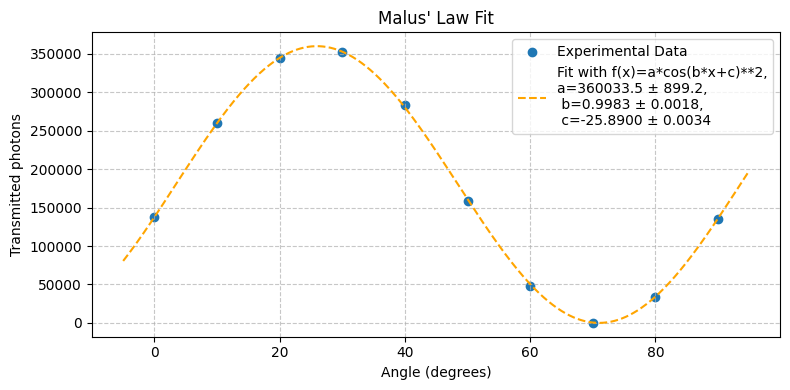

In [5]:
plt.figure(figsize=(8, 4))

plt.scatter(angles, transmitted_photons, label='Experimental Data')

popt_coherent_static, pcov_static = curve_fit(malus_function, angles, transmitted_photons, p0=[45000.0, 1.0, 90.0])

x_angles = np.arange(min(angles)-5, max(angles)+5, 0.1)
plt.plot(x_angles, malus_function(x_angles, *popt_coherent_static), color='orange', linestyle='--',
         label=f'Fit with f(x)=a*cos(b*x+c)**2,\n'
               f'a={popt_coherent_static[0]:.1f} ± {np.sqrt(pcov_static[0][0]):.1f},\n '
               f'b={popt_coherent_static[1]:.4f} ± {np.sqrt(pcov_static[1][1]):.4f},\n '
               f'c={popt_coherent_static[2]/np.pi*90 - 7.25*360:.4f} ± {np.sqrt(pcov_static[2][2]):.4f}')

plt.xlabel('Angle (degrees)')
plt.ylabel('Transmitted photons')
plt.title('Malus\' Law Fit')
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### GRA Experiment

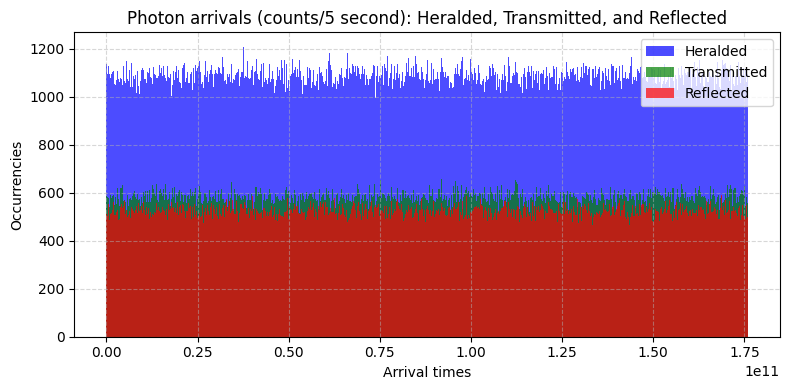

In [6]:
set3_heralded = set3[set3[:, 1] == 1]
set3_transmitted = set3[set3[:, 1] == 2]
set3_reflected = set3[set3[:, 1] == 3]

plt.figure(figsize=(8, 4))

plt.hist(set3_heralded[:, 0], bins=1000, color='blue', alpha=0.7, label='Heralded')
plt.hist(set3_transmitted[:, 0], bins=1000, color='green', alpha=0.7, label='Transmitted')
plt.hist(set3_reflected[:, 0], bins=1000, color='red', alpha=0.7, label='Reflected')

plt.xlabel('Arrival times')
plt.ylabel('Occurrencies')
plt.title('Photon arrivals (counts/5 second): Heralded, Transmitted, and Reflected')
plt.legend(loc='upper right')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [7]:
def time_differences_between_channels(data, channel_a, channel_b, threshold):
  times_a = data[data[:, 1] == channel_a][:, 0]
  times_b = data[data[:, 1] == channel_b][:, 0]
  
  time_differences = []
  
  for t_a in times_a:
    closest_t_b = times_b[np.abs(times_b - t_a).argmin()]
    delay = t_a - closest_t_b
    if abs(delay) < threshold:
      time_differences.append(delay)
    else:
      time_differences.append(None)

  return np.array([t for t in time_differences if t is not None])

In [8]:
time_window = 50
t_diff_31 = time_differences_between_channels(set3, 3, 1, time_window)
t_diff_21 = time_differences_between_channels(set3, 2, 1, time_window)

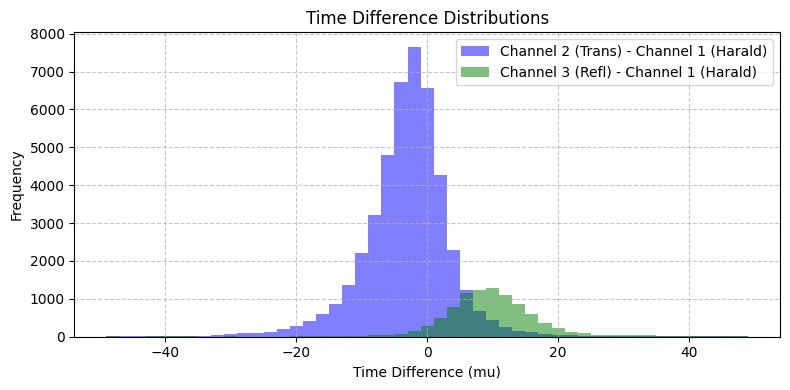

In [9]:
max_diff = max(max(np.abs(t_diff_21)), max(np.abs(t_diff_31)))
bins = np.linspace(-max_diff, max_diff, time_window)

plt.figure(figsize=(8, 4))

plt.hist(t_diff_21, bins=bins, color='blue', alpha=0.5, label='Channel 2 (Trans) - Channel 1 (Harald)')
plt.hist(t_diff_31, bins=bins, color='green', alpha=0.5, label='Channel 3 (Refl) - Channel 1 (Harald)')

plt.xlabel('Time Difference (mu)')
plt.ylabel('Frequency')
plt.title('Time Difference Distributions')
plt.legend(loc='upper right')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

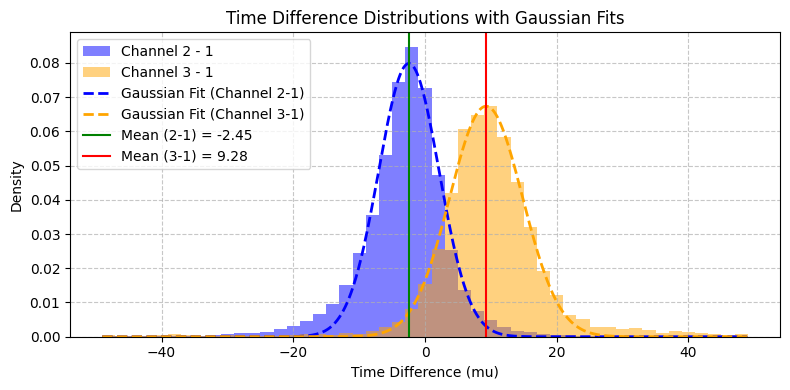

In [10]:
def gaussian(x, amplitude, mean, stddev):
  return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

max_diff = max(max(np.abs(t_diff_21)), max(np.abs(t_diff_31)))
bins = np.linspace(-max_diff, max_diff, time_window)

plt.figure(figsize=(8, 4))

counts_21, bin_edges_21, _ = plt.hist(t_diff_21, bins=bins, color='blue', alpha=0.5, density=True, label='Channel 2 - 1')
counts_31, bin_edges_31, _ = plt.hist(t_diff_31, bins=bins, color='orange', alpha=0.5, density=True, label='Channel 3 - 1')

bin_centers_21 = (bin_edges_21[:-1] + bin_edges_21[1:]) / 2
bin_centers_31 = (bin_edges_31[:-1] + bin_edges_31[1:]) / 2

x_21 = np.arange(min(bin_edges_21), max(bin_edges_21), 0.1)
x_31 = np.arange(min(bin_edges_31), max(bin_edges_31), 0.1)

popt_21, pcov21 = curve_fit(gaussian, bin_centers_21, counts_21, p0=[1, np.mean(t_diff_21), np.std(t_diff_21)])
popt_31, pcov31 = curve_fit(gaussian, bin_centers_31, counts_31, p0=[1, np.mean(t_diff_31), np.std(t_diff_31)])

plt.plot(x_21, gaussian(x_21, *popt_21), color='blue', linestyle='--', linewidth=2, label=f'Gaussian Fit (Channel 2-1)')
plt.plot(x_31, gaussian(x_31, *popt_31), color='orange', linestyle='--', linewidth=2, label=f'Gaussian Fit (Channel 3-1)')
plt.axvline(popt_21[1], color='green', label=f'Mean (2-1) = {round(popt_21[1], 2)}')
plt.axvline(popt_31[1], color='red', label=f'Mean (3-1) = {round(popt_31[1], 2)}')


plt.xlabel('Time Difference (mu)')
plt.ylabel('Density')
plt.title('Time Difference Distributions with Gaussian Fits')
plt.legend(loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
mean_31 = np.mean(t_diff_31)
mean_21 = np.mean(t_diff_21)
sd_21 = np.std(t_diff_21)
sd_31 = np.std(t_diff_31)

print("NUMERICAL STATISTICS:\n")

print(f"Delay Channel 2 (Trans) - Channel 1 (Harald):")
print(f"Mean: {round(mean_21, 2)} +/- {round(sd_21 / np.sqrt(len(t_diff_21)), 2)} mu")
print(f"Std: {round(sd_21, 2)} +/- {round(sd_21 / np.sqrt(2 * (len(t_diff_21) - 1)), 2)} mu\n")
print(f"Delay Channel 3 (Refl) - Channel 1 (Harald):")
print(f"Mean: {mean_31} +/- {round(sd_31 / np.sqrt(len(t_diff_31)), 2)} mu")
print(f"Std: {round(sd_31, 2)} +/- {round(sd_31 / np.sqrt(2 * (len(t_diff_31) - 1)), 2)} mu")

NUMERICAL STATISTICS:

Delay Channel 2 (Trans) - Channel 1 (Harald):
Mean: -3.48 +/- 0.03 mu
Std: 6.99 +/- 0.02 mu

Delay Channel 3 (Refl) - Channel 1 (Harald):
Mean: 9.304695725415877 +/- 0.09 mu
Std: 9.01 +/- 0.07 mu


In [12]:
print("FIT STATISTICS:\n")

print("OPTIMAL PARAMETERS FOR CHANNEL 2 - 1:")
print(f"Amplitude = {round(popt_21[0], 3)} +/- {round(np.sqrt(pcov21[0,0]), 3)} mu")
print(f"Mean = {round(popt_21[1], 2)} +/- {round(np.sqrt(pcov21[1,1]), 2)} mu")
print(f"Std = {round(popt_21[2], 2)} +/- {round(np.sqrt(pcov21[2,2]), 2)} mu\n")

print("OPTIMAL PARAMETERS FOR CHANNEL 3 - 1:")
print(f"Amplitude = {round(popt_31[0], 3)} +/- {round(np.sqrt(pcov31[0,0]), 3)} mu")
print(f"Mean = {round(popt_31[1], 2)} +/- {round(np.sqrt(pcov31[1,1]), 2)} mu")
print(f"Std = {round(popt_31[2], 2)} +/- {round(np.sqrt(pcov31[2,2]), 2)} mu\n")

FIT STATISTICS:

OPTIMAL PARAMETERS FOR CHANNEL 2 - 1:
Amplitude = 0.08 +/- 0.002 mu
Mean = -2.45 +/- 0.1 mu
Std = 4.59 +/- 0.1 mu

OPTIMAL PARAMETERS FOR CHANNEL 3 - 1:
Amplitude = 0.067 +/- 0.001 mu
Mean = 9.28 +/- 0.07 mu
Std = 5.52 +/- 0.07 mu



In [13]:
expected_counts_21 = gaussian(bin_centers_21, *popt_21) * np.diff(bin_edges_21)
rmse_21 = np.sqrt(np.mean((counts_21 - expected_counts_21) ** 2))
print(f"RMSE for fit delay channel 2-1: {round(rmse_21, 4)}")

expected_counts_31 = gaussian(bin_centers_31, *popt_31) * np.diff(bin_edges_31)
rmse_31 = np.sqrt(np.mean((counts_31 - expected_counts_31) ** 2))
print(f"RMSE for fit delay channel 3-1:: {round(rmse_31, 4)}")

RMSE for fit delay channel 2-1: 0.0231
RMSE for fit delay channel 3-1:: 0.0213


### Coincidences analysis

In [14]:
def double_coincidences(data, channel_a, channel_b, threshold):
  times_a = data[data[:, 1] == channel_a][:, 0]
  times_b = data[data[:, 1] == channel_b][:, 0]
  
  N = 0
  
  for t_a in times_a:
    closest_t_b = times_b[np.abs(times_b - t_a).argmin()]
    delay = t_a - closest_t_b
    N+= int(abs(delay) < threshold)

  return N

def triple_coincidences(data, threshold):
  times_a = data[data[:, 1] == 1][:, 0]
  times_b = data[data[:, 1] == 2][:, 0]
  times_c = data[data[:, 1] == 3][:, 0]
  
  N = 0
  
  for t_a in times_a:
    closest_t_b = times_b[np.abs(times_b - t_a).argmin()]
    delay = t_a - closest_t_b
    if abs(delay) < threshold:
      closest_t_c = times_c[np.abs(times_c - closest_t_b).argmin()]
      delay2 = closest_t_b - closest_t_c
      N += int(abs(delay2) < threshold)

  return N

def alpha_compute(data, window):
  transmitted = data[data[:, 1] == 2][:, 0]
  reflected = data[data[:, 1] == 3][:, 0]
  
  N = len(data) / 2
  N_c = double_coincidences(data, 2, 3, window)
  p_c = N_c / N
  p_t = len(transmitted) / N
  p_r = len(reflected) / N
  
  sigma_c = np.sqrt(p_c*(1-p_c)/N)
  sigma_t = np.sqrt(p_t*(1-p_t)/N)
  sigma_r = np.sqrt(p_r*(1-p_r)/N)
  
  alpha = p_c / (p_r*p_t)
  sigma_alpha = alpha * np.sqrt((sigma_c / p_c)**2 + (sigma_t / p_t)**2 + (sigma_r / p_r)**2)
  
  return alpha, sigma_alpha

In [15]:
window = 50
double_h_t_number = double_coincidences(set3, 1, 2, window)
double_h_r_number = double_coincidences(set3, 1, 3, window)
double_t_r_number = double_coincidences(set3, 2, 3, window)
triple_coin_number = triple_coincidences(set3, window)

In [16]:
alpha, std_alpha = alpha_compute(set3, 50)

In [17]:
print(f"Number of tripe coincidences: {triple_coin_number}")
print(f"Number of double coincidences (H-T): {double_h_t_number}")
print(f"Number of double coincidences (H-R): {double_h_r_number}")
print(f"Number of double coincidences (T-R): {double_t_r_number}")

Number of tripe coincidences: 26
Number of double coincidences (H-T): 45180
Number of double coincidences (H-R): 9498
Number of double coincidences (T-R): 175


In [18]:
print(f"Alpha: {round(alpha, 5)} +/- {round(std_alpha, 5)}")

Alpha: 0.00063 +/- 5e-05


### Quantum Random Number Generator

In [19]:
def bits_to_byte(bits):
  byte = 0
  for bit in bits:
    byte = (byte << 1) | bit
  return byte
  
def qrng_list(data, channel_a, channel_b):
  bits_list = []
  bytes_list = []

  for i in range(0, len(data)):
    if data[i, 1] == channel_a:
      bits_list.append(0)
    elif data[i, 1] == channel_b:
      bits_list.append(1)

  bits_list = np.array(bits_list)
  
  for i in range(0, len(bits_list), 8):
    byte_chunk = bits_list[i:i+8]
    if len(byte_chunk) == 8:
      bytes_list.append(bits_to_byte(byte_chunk))
  
  return bytes_list

In [20]:
bytes_list = qrng_list(set3, 2, 3)

with open("/mnt/c/Users/Utente/QOL/random/data/qrng_lab2.bin", "wb") as file:
  file.write(bytearray(bytes_list))

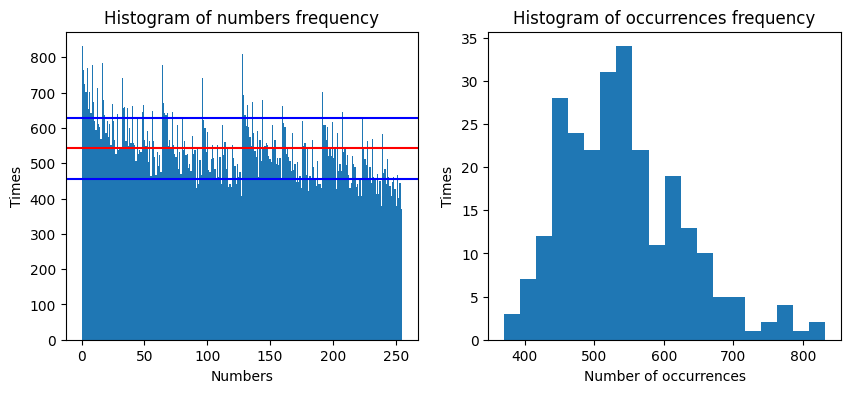

Bytes:
Mean: 120.81196883086926, Standard Deviation: 74.15602669131552

Counts:
Mean: 541.90234375, Standard Deviation: 86.51712616301374


In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

counts_qrng, bin_edges_qrng, _ = ax1.hist(bytes_list, bins=max(bytes_list)+1)
mean_qrng = np.mean(counts_qrng)
std_qrng = np.std(counts_qrng)

ax1.axhline(y=mean_qrng, color='r')
ax1.axhline(y=mean_qrng - std_qrng, color='b')
ax1.axhline(y=mean_qrng + std_qrng, color='b')
ax1.set_xlabel("Numbers")
ax1.set_ylabel("Times")
ax1.set_title("Histogram of numbers frequency")

ax2.hist(counts_qrng, bins=20)
ax2.set_xlabel("Number of occurrences")
ax2.set_ylabel("Times")
ax2.set_title("Histogram of occurrences frequency")

plt.show()

print(f'Bytes:\nMean: {np.mean(bytes_list)}, Standard Deviation: {np.std(bytes_list)}\n')
print(f'Counts:\nMean: {mean_qrng}, Standard Deviation: {std_qrng}')

In [22]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_choices = []

x_vals = []
y_vals = []
z_vals = []

k = 0
while k < len(bytes_list) - 2:
  x_vals.append(bytes_list[k])
  y_vals.append(bytes_list[k+1])
  z_vals.append(bytes_list[k+2])
  color_choices.append(random.choice(colors))
  k += 3

fig = go.Figure(data=[go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers', marker=dict(size=2, color=color_choices, opacity=0.6))])

fig.update_layout(
  title="Interactive 3D Scatter Plot - QRNG",
  scene=dict(
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    zaxis_title='Z Axis'
  ),
  width=1000, height=1000
)

fig.show()